In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

import jax.numpy as jnp
from jax import lax, ops, random, vmap
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import ELBO, SVI, Predictive, init_to_value, log_likelihood, MCMC, NUTS
from numpyro.infer.autoguide import AutoLaplaceApproximation

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

7e2

In [2]:
p = jnp.array((.7, .3))
-sum(p * jnp.log(p))

0.6108643412590027

7e3

In [3]:
p = jnp.array((.2, .25, .25, .3))
-sum(p * jnp.log(p))

1.3762266337871552

7e4

In [4]:
p = jnp.array((1/3,1/3,1/3)) # events that never happen drop out
-sum(p * jnp.log(p))

1.0986123383045197

7h1

In [5]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d["age"] = (d["age"] - d["age"].mean()) / d["age"].std()

In [6]:
shuffled = d.sample(frac=1)
d1,d2 = onp.array_split(shuffled, 2)  

In [56]:
def m1(height=None, age=None):
    a = numpyro.sample("a", dist.Normal(140, 30))
    b1 = numpyro.sample("b1", dist.Normal(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * age)
    sigma = numpyro.sample("sigma", dist.Normal(30, 10))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

def m2(height=None, age=None):
    a = numpyro.sample("a", dist.Normal(140, 30))
    b1 = numpyro.sample("b1", dist.Normal(0, 50))
    b2 = numpyro.sample("b2", dist.Normal(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * age + b2 * age ** 2)
    sigma = numpyro.sample("sigma", dist.Normal(30, 10))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

def m3(height=None, age=None):
    a = numpyro.sample("a", dist.Normal(140, 30))
    b1 = numpyro.sample("b1", dist.Normal(0, 50))
    b2 = numpyro.sample("b2", dist.Normal(0, 50))
    b3 = numpyro.sample("b3", dist.Normal(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * age + b2 * age ** 2 + b3 * age ** 3)
    sigma = numpyro.sample("sigma", dist.Normal(30, 10))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

def m4(height=None, age=None):
    a = numpyro.sample("a", dist.Normal(140, 30))
    b1 = numpyro.sample("b1", dist.Normal(0, 50))
    b2 = numpyro.sample("b2", dist.Normal(0, 50))
    b3 = numpyro.sample("b3", dist.Normal(0, 50))
    b4 = numpyro.sample("b4", dist.Normal(0, 50))
    mu = numpyro.deterministic(
        "mu", a + b1 * age + b2 * age ** 2 + b3 * age ** 3 + b4 * age ** 4
    )
    sigma = numpyro.sample("sigma", dist.Normal(30, 10))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

def m5(height=None, age=None):
    a = numpyro.sample("a", dist.Normal(140, 30))
    b1 = numpyro.sample("b1", dist.Normal(0, 50))
    b2 = numpyro.sample("b2", dist.Normal(0, 50))
    b3 = numpyro.sample("b3", dist.Normal(0, 50))
    b4 = numpyro.sample("b4", dist.Normal(0, 50))
    b5 = numpyro.sample("b5", dist.Normal(0, 50))
    mu = numpyro.deterministic(
        "mu", a + b1 * age + b2 * age ** 2 + b3 * age ** 3 + b4 * age ** 4 + b5 * age ** 5
    )
    sigma = numpyro.sample("sigma", dist.Normal(30, 10))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

def m6(height=None, age=None):
    a = numpyro.sample("a", dist.Normal(140, 30))
    b1 = numpyro.sample("b1", dist.Normal(0, 50))
    b2 = numpyro.sample("b2", dist.Normal(0, 50))
    b3 = numpyro.sample("b3", dist.Normal(0, 50))
    b4 = numpyro.sample("b4", dist.Normal(0, 50))
    b5 = numpyro.sample("b5", dist.Normal(0, 50))
    b6 = numpyro.sample("b6", dist.Normal(0, 50))
    mu = numpyro.deterministic(
        "mu", a + b1 * age + b2 * age ** 2 + b3 * age ** 3 + b4 * age ** 4 + b5 * age ** 5 + b6 * age ** 6
    )
    sigma = numpyro.sample("sigma", dist.Normal(30, 10))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

In [61]:
age_seq = jnp.linspace(d1.age.min(), d1.age.max(), 100)

def run_for(model):
    mcmc = MCMC(NUTS(model), 500, 1000)
    mcmc.run(rng_key_, height=d1.height.values, age=d1.age.values)
    mcmc.print_summary()
    post_samples = mcmc.get_samples()
    logprob = log_likelihood(
        model, post_samples, age=d1.age.values, height=d1.height.values
    )
    return (
        az.from_dict(sample_stats={"log_likelihood": logprob["height"][None, ...]}),
        Predictive(model, post_samples, return_sites=["mu"])(rng_key_, age=age_seq)["mu"]
    )

models = (m1, m2, m3, m4, m5, m6)
azs, preds = zip(*[run_for(model) for model in models])
azs = dict(zip([model.__name__ for model in models], azs))

#az.waic(az_m1, scale="deviance")
az.compare(azs, ic="waic", scale="deviance")

sample: 100%|██████████| 1500/1500 [00:04<00:00, 310.11it/s, 7 steps of size 7.22e-01. acc. prob=0.94]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a    138.15      1.20    138.19    136.14    140.12    906.82      1.00
        b1     19.41      1.14     19.38     17.41     21.18    848.92      1.00
     sigma     20.55      0.90     20.49     19.08     22.05    752.91      1.00

Number of divergences: 0
sample: 100%|██████████| 1500/1500 [00:04<00:00, 308.39it/s, 7 steps of size 5.24e-01. acc. prob=0.93]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a    152.32      1.04    152.33    150.70    154.11    760.07      1.00
        b1     26.45      0.89     26.41     25.15     28.05    878.97      1.00
        b2    -13.85      0.68    -13.84    -15.03    -12.78    698.32      1.00
     sigma     12.76      0.54     12.74     11.86     13.60    922.58      1.00

Number of divergences: 0
  0%|      

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m4,0,1894.85,5.64174,0,0.488089,23.2626,0,True,deviance
m5,1,1895.77,6.3127,0.917596,0.297322,23.4362,1.58842,False,deviance
m6,2,1896.86,7.44574,2.01281,0.21439,22.0641,2.7663,True,deviance
m3,3,1937.91,5.99131,43.0641,0.000198171,23.7932,13.2055,True,deviance
m2,4,2159.4,5.67234,264.547,2.33536e-40,24.0851,25.2087,True,deviance
m1,5,2415.54,3.1045,520.688,1.83064e-93,24.3522,27.9414,False,deviance


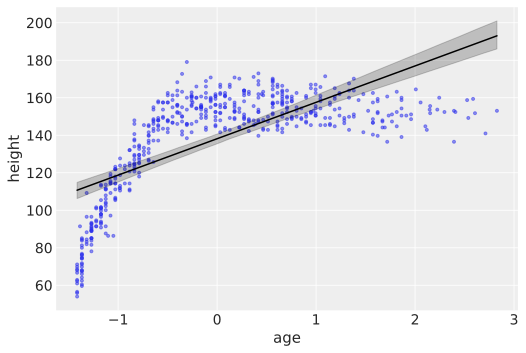

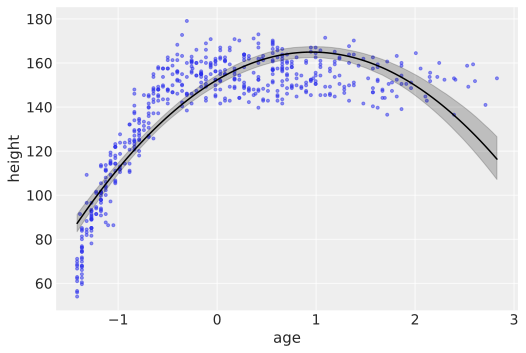

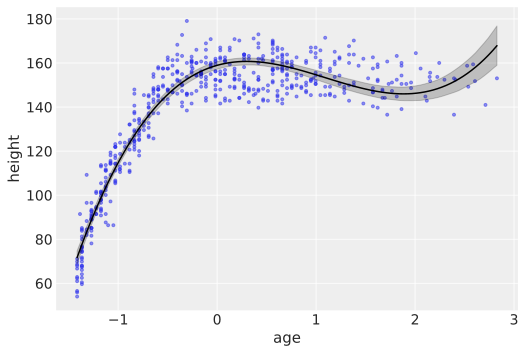

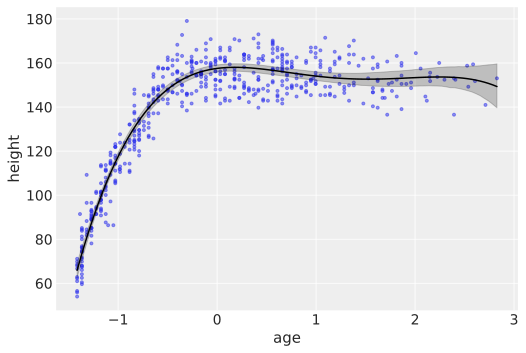

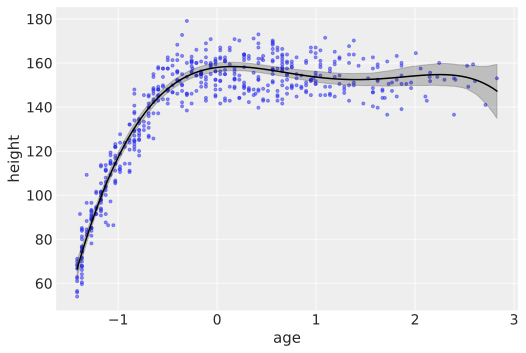

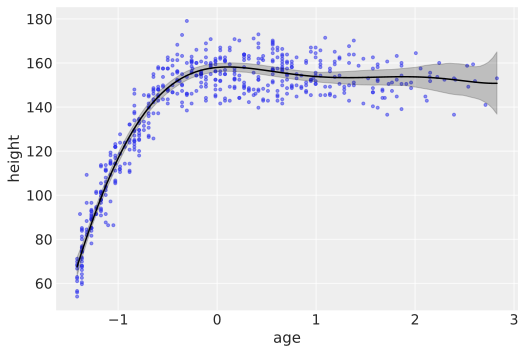

In [71]:
for pred in preds:
    az.plot_pair(
        d[["age", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
    )
    mu_mean = jnp.mean(pred, 0)
    mu_PI = jnp.percentile(pred, q=(1.5, 98.5), axis=0)
    plt.plot(age_seq, mu_mean, "k")

    plt.fill_between(age_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)

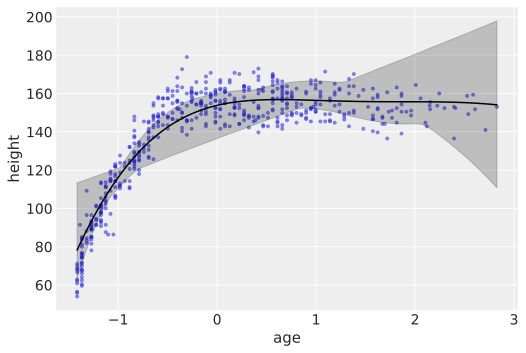

In [81]:
# 7h3 - quick go at naive averaging over proper ensembling - does still show the widening
#       comp interval as age moves past 2

az.plot_pair(
    d[["age", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
ens_mean = onp.mean(jnp.array(preds), axis=(0,1))
ens_PI = onp.percentile(jnp.array(preds), q=(1.5, 98.5), axis=(0,1))    # jnp doesn't have tuple support yet

plt.plot(age_seq, ens_mean, "k")
plt.fill_between(age_seq, ens_PI[0], ens_PI[1], color="k", alpha=0.2)
